# SkimLit
The purpose of this notebok is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'l be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to acheive their best results is available here: https://arxiv.org/abs/1612.05251



## Get data
Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


**Note:** `PubMed 20k is asubset of PubMed 200K, i.e, any abstract present in PubMed 20K is also present in PubMed 200k.`

In [6]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [7]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [8]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """

    with open(filename, "r") as f:
        return f.readlines()

In [10]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt') # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

### Data Representation

[{'line_number': 0,
  'target': 'BACKGROUND',

  'text': "Emotional eating is associated with overeating and the development of obesity .\n",
  
  'total_lines': 11},
  
  ....]


Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [12]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dicionaries of abstract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename)  # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split('\t') # split target label from text
                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [13]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))


180040 30212 30135


In [14]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to futher visualize it.

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

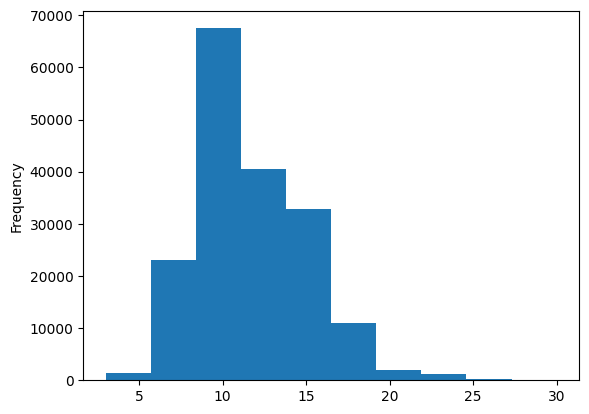

In [17]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View the 10 liens of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [20]:
# One hot encode labels
from sklearn.preprocessing import  OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # We want non_sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0: Naive Bayes with TF-IDF encoder


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
A function to compare predictions across different metrics (accuracy, precision, recall and f1).

In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data (the text) for deep sequence models
Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

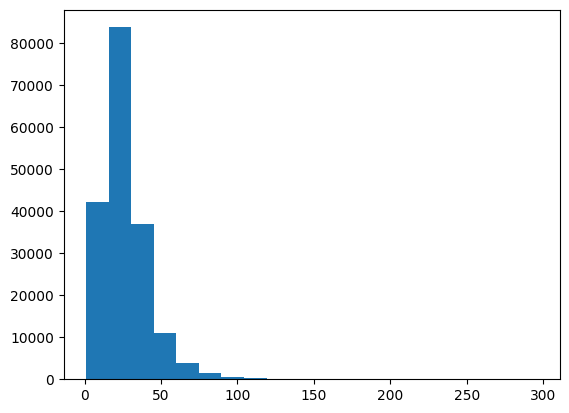

In [30]:
# What's the distrubution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20)
plt.show()

In [31]:
# How long of a sentence length cover 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length if the training set
max(sent_lens)

296

### Create text vectorizer layer

We want ot make a layer which maps our texts from words to numbers.

In [33]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired ouput lenght of vecotized sequences

In [35]:
# Adapth text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
registered july @ , @ .

Length of text: 23

Vectorized text: [[ 394 1570    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create text embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # Length of vocab
                               output_dim = 128, # Note: Different sizes result in drastically different number of parameters to train)
                               mask_zero = True, # use masking to handle variable sequence lengths (save space)
                               name = 'token_embedding')

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
 registered july @ , @ .

Sentence after vectorization (before embedding):
 [[ 394 1570    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.02408607  0.00536148 -0.01483909 ... -0.02667901  0.0087083
    0.01913098]
  [ 0.03858036 -0.0189279   0.03946367 ...  0.02220179  0.04630553
   -0.01070225]
  [-0.01937926  0.03499558 -0.00707455 ... -0.01156806  0.0098971
    0.04026613]
  ...
  [-0.01937926  0.03499558 -0.00707455 ... -0.01156806  0.0098971
    0.04026613]
  [-0.01937926  0.03499558 -0.00707455 ... -0.01156806  0.0098971
    0.04026613]
  [-0.01937926  0.03499558 -0.00707455 ... -0.01156806  0.0098971
    0.04026613]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performace
* https://www.tensorflow.org/guide/data

In [41]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="sparse_categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [45]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 60s 105ms/step - loss: 0.9236 - accuracy: 0.6354 - val_loss: 0.6861 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 56s 100ms/step - loss: 0.6561 - accuracy: 0.7587 - val_loss: 0.6332 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 56s 100ms/step - loss: 0.6140 - accuracy: 0.7766 - val_loss: 0.5944 - val_accuracy: 0.7809


In [46]:
# Evaluate on whole validaion dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5937 - accuracy: 0.7866


[0.5937376022338867, 0.7865749001502991]

In [47]:
# Make predictions (our model predicts predicton probablities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.7852266e-01, 1.4331710e-01, 6.4873375e-02, 2.9012865e-01,
         2.3158140e-02],
        [4.2817938e-01, 2.7573222e-01, 1.3196751e-02, 2.7092642e-01,
         1.1965142e-02],
        [1.5262878e-01, 6.7088623e-03, 1.8156276e-03, 8.3879501e-01,
         5.1772153e-05],
        ...,
        [1.0357037e-05, 6.7025586e-04, 8.9634478e-04, 4.0864647e-06,
         9.9841893e-01],
        [5.2594386e-02, 4.8903146e-01, 6.7985751e-02, 6.7292899e-02,
         3.2309544e-01],
        [1.5647906e-01, 7.3666370e-01, 5.1277947e-02, 2.7868036e-02,
         2.7711211e-02]], dtype=float32),
 (30212, 5))

In [48]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.65748709122204,
 'precision': 0.7832125850405172,
 'recall': 0.7865748709122203,
 'f1': 0.7840427951551049}

## Model 2: TensorFlow Hub Pretrained Feature Extractor

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later create USE pretrained embeddings.

In [50]:
# Pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name = 'universal_sentence_encoder')


In [51]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 from @ to @ , @ patients were enrolled , of whom @ were allocated to the chemoradiotherapy group and @ to the chemotherapy group .
Sentence after embedding:
[-0.02456464  0.02666698 -0.03976405 -0.03122023 -0.03993614 -0.04087665
  0.03677747 -0.04305473 -0.08286828 -0.02908666  0.0922824   0.00943036
  0.02310683  0.05791616  0.00940526  0.0452301  -0.09295573 -0.03887412
 -0.06859477  0.02588526  0.02726194  0.0807971  -0.04041705 -0.01783713
  0.00071825  0.04168299  0.00547112  0.04417228  0.07784956  0.04370263]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained from TensorFlow Hub

In [52]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
# Note: You could add more layers here if you wanted to
outputs = layers.Dense(5, activation = 'softmax')(x) # Create the output layer

model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_2_USE')

# Compile the model
model_2.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics = ['accuracy'])

In [53]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
# Fit model_2 to the data
model_2_history = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9138 - accuracy: 0.6485 - val_loss: 0.7983 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7699 - accuracy: 0.7013 - val_loss: 0.7573 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7545 - accuracy: 0.7115 - val_loss: 0.7418 - val_accuracy: 0.7128


In [55]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7435 - accuracy: 0.7124


[0.743496298789978, 0.7123990654945374]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.3971708e-01, 3.6579853e-01, 2.8854734e-03, 1.8360315e-01,
        7.9956753e-03],
       [3.3080742e-01, 5.2087247e-01, 3.9197076e-03, 1.4090444e-01,
        3.4960436e-03],
       [2.3631480e-01, 1.3806400e-01, 2.4008024e-02, 5.6750250e-01,
        3.4110568e-02],
       ...,
       [1.4644462e-03, 6.7622373e-03, 6.6916920e-02, 8.6590357e-04,
        9.2399043e-01],
       [3.6890574e-03, 4.4810332e-02, 2.0251991e-01, 1.4272158e-03,
        7.4755341e-01],
       [1.7300786e-01, 2.3233938e-01, 5.2707744e-01, 5.0499444e-03,
        6.2525406e-02]], dtype=float32)

In [57]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Caluclate results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.23990467363961,
 'precision': 0.7129151468211921,
 'recall': 0.7123990467363961,
 'f1': 0.7094479697910472}

## Model 3: Conv1D with character embeddings

The paper which we're replicating statest they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters of we want to use char-level embeddings

### Creating a chracter-level tokenizer

In [59]:
# Make function to split sentence into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'f r o m   @   t o   @   ,   @   p a t i e n t s   w e r e   e n r o l l e d   ,   o f   w h o m   @   w e r e   a l l o c a t e d   t o   t h e   c h e m o r a d i o t h e r a p y   g r o u p   a n d   @   t o   t h e   c h e m o t h e r a p y   g r o u p   .'

In [60]:
# Split sequence-level data splits into chracter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# What's the average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

149.3662574983337

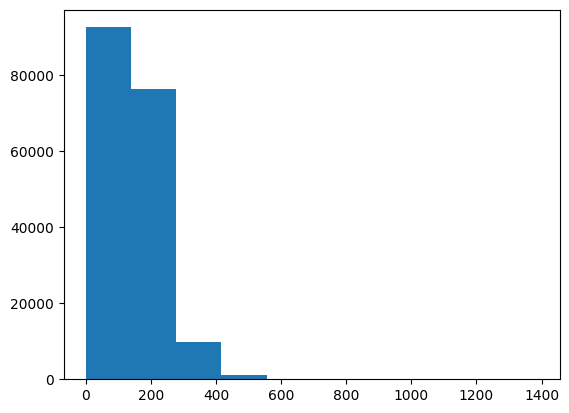

In [62]:
# Check the distrubution of our sequence at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins = 10)
plt.show()

In [63]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOv = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = 'lower_and_strip_punctuation',
                                    name = "char_vectorizer")

In [66]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [67]:
# Check character vocab size
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars)}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars)}")

Charified text:
 p a t i e n t s   u n d e r g o i n g   u r g e n t   e n d o t r a c h e a l   i n t u b a t i o n   w e r e   r a n d o m i z e d   t o   g l i d e s c o p e   v i d e o   l a r y n g o s c o p y   o r   d i r e c t   l a r y n g o s c o p y   a s   t h e   p r i m a r y   i n t u b a t i o n   d e v i c e   .

Length of random_train_chars: 313

Vectorized chars:
 [[14  5  3  4  2  6  3  9 16  6 10  2  8 18  7  4  6 18 16  8 18  2  6  3
   2  6 10  7  3  8  5 11 13  2  5 12  4  6  3 16 22  5  3  4  7  6 20  2
   8  2  8  5  6 10  7 15  4 25  2 10  3  7 18 12  4 10  2  9 11  7 14  2
  21  4 10  2  7 12  5  8 19  6 18  7  9 11  7 14 19  7  8 10  4  8  2 11
   3 12  5  8 19  6 18  7  9 11  7 14 19  5  9  3 13  2 14  8  4 15  5  8
  19  4  6  3 16 22  5  3  4  7  6 10  2 21  4 11  2  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

### Creating a character-level embedding

In [69]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # Number of different characters
                              output_dim = 25, # This is the size of char embedding in the paper
                              mask_zero = True,
                              name = 'char_embed')

In [70]:
# Test our character embedding layer
print(f"Charified text: {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text: p a t i e n t s   u n d e r g o i n g   u r g e n t   e n d o t r a c h e a l   i n t u b a t i o n   w e r e   r a n d o m i z e d   t o   g l i d e s c o p e   v i d e o   l a r y n g o s c o p y   o r   d i r e c t   l a r y n g o s c o p y   a s   t h e   p r i m a r y   i n t u b a t i o n   d e v i c e   .

Embedded chars (after vectorization and embedding):
 [[[-0.02274091  0.02026782  0.00349119 ...  0.01829522 -0.03624234
    0.01855518]
  [-0.04497646 -0.00032462 -0.00044455 ... -0.00303347  0.03328972
   -0.01647879]
  [ 0.03180781  0.02087884 -0.00664724 ...  0.04740978  0.02476007
    0.01067888]
  ...
  [ 0.03099513  0.04514979  0.04941552 ... -0.02573005  0.02117671
   -0.01143433]
  [ 0.03099513  0.04514979  0.04941552 ... -0.02573005  0.02117671
   -0.01143433]
  [ 0.03099513  0.04514979  0.04941552 ... -0.02573005  0.02117671
   -0.01143433]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [71]:
# Make Conv1D on character embeddings
inputs = tf.keras.Input(shape = (1, ), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3_conv1D_char_embeddings")

# Compile the model
model_3.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics = ['accuracy'])

In [72]:
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [73]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [74]:
# Fit the model on char only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 21ms/step - loss: 1.2761 - accuracy: 0.4899 - val_loss: 1.0635 - val_accuracy: 0.5735
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 1.0125 - accuracy: 0.5971 - val_loss: 0.9352 - val_accuracy: 0.6366
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 0.9265 - accuracy: 0.6356 - val_loss: 0.8616 - val_accuracy: 0.6732


In [75]:
# Make predictions with character model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 7s 8ms/step


array([[0.18008615, 0.33195853, 0.14515066, 0.27433333, 0.06847133],
       [0.1446549 , 0.736255  , 0.01144635, 0.06489231, 0.04275139],
       [0.06436909, 0.21686392, 0.2547593 , 0.36641353, 0.09759411],
       ...,
       [0.01668437, 0.04825215, 0.06499773, 0.01355036, 0.8565154 ],
       [0.0187422 , 0.1047537 , 0.19476134, 0.04298307, 0.63875973],
       [0.47842664, 0.35924897, 0.07836709, 0.06764205, 0.01631526]],
      dtype=float32)

In [76]:
# Convert probabilites probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [77]:
# Calculate results for Conv1D model
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 66.2121011518602,
 'precision': 0.6541737185489361,
 'recall': 0.6621210115186019,
 'f1': 0.6518336321138046}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1  & 2 with a concatenate (`layer.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilites as output


In [78]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
text_vectors = text_vectorizer(token_inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector

# token_embeddings = tf_hub_embedding_layer(token_inputs)

token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [79]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorization[1][0]']  
 )                                                                                                
                                                                  

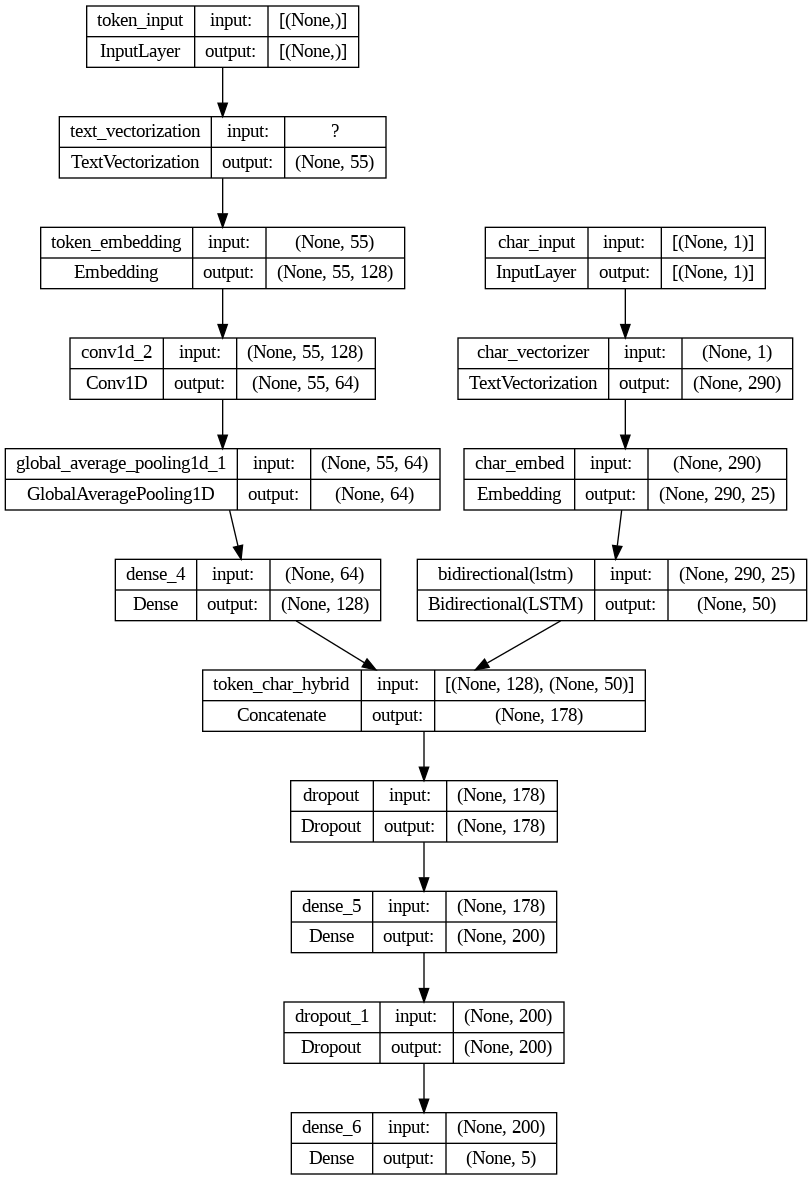

In [80]:
# Plot hybrid token and character model
import pydot
import graphviz
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [81]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Combining token and character data into a tf.data.Dataset

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [84]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 251s 429ms/step - loss: 0.6777 - accuracy: 0.7434 - val_loss: 0.5930 - val_accuracy: 0.7856
Epoch 2/3
562/562 [==============================] - 235s 419ms/step - loss: 0.5044 - accuracy: 0.8195 - val_loss: 0.6004 - val_accuracy: 0.7793
Epoch 3/3
562/562 [==============================] - 244s 434ms/step - loss: 0.4828 - accuracy: 0.8307 - val_loss: 0.5692 - val_accuracy: 0.7926


In [85]:
# Evaluate on the whole val dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 63s 67ms/step - loss: 0.5787 - accuracy: 0.7888


[0.5787319540977478, 0.7887594103813171]

In [86]:
# Make predictions using the token-char hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 65s 66ms/step


array([[6.38506711e-01, 8.17977488e-02, 2.23420281e-02, 2.51502305e-01,
        5.85116120e-03],
       [3.77806515e-01, 1.71425968e-01, 1.63502414e-02, 4.26349819e-01,
        8.06757901e-03],
       [1.32402569e-01, 5.83367713e-04, 1.08253723e-03, 8.65893960e-01,
        3.74842857e-05],
       ...,
       [6.87209024e-07, 3.05456691e-04, 5.84325520e-03, 2.39323583e-07,
        9.93850350e-01],
       [1.15760274e-01, 4.86222655e-01, 1.27282068e-01, 6.33421615e-02,
        2.07392842e-01],
       [2.24953722e-02, 9.61690485e-01, 4.75705508e-03, 3.37623572e-03,
        7.68079609e-03]], dtype=float32)

In [87]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 1, 1])>

In [88]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 78.87594333377466,
 'precision': 0.7903954363772274,
 'recall': 0.7887594333377466,
 'f1': 0.7887702980947483}

{'accuracy': 78.87594333377466,
 'precision': 0.7903954363772274,
 'recall': 0.7887594333377466,
 'f1': 0.7887702980947483}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [93]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note** Any engineered features used to train a modle need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [95]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

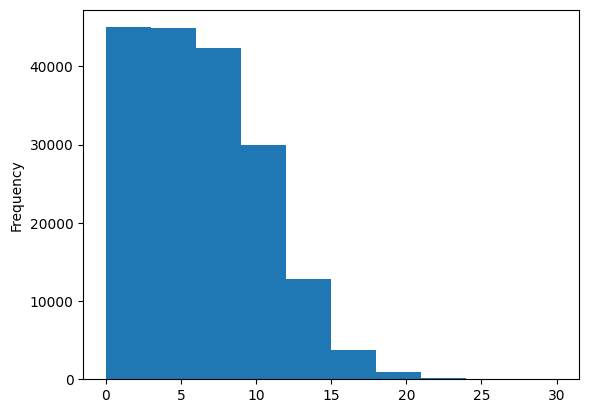

In [96]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [98]:
# Use Tensorflow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [101]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

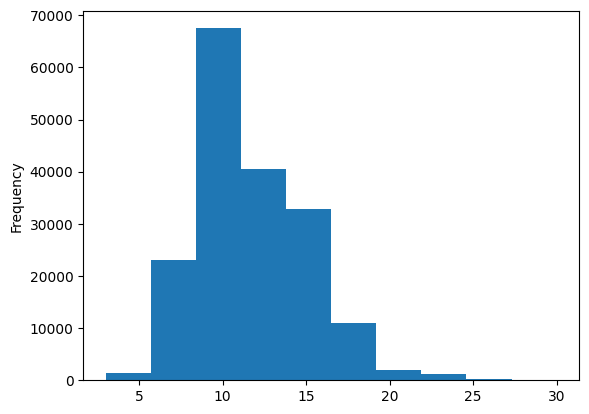

In [102]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [103]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [104]:
# Use Tensorflow to create one-hot encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities.
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

In [111]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name = 'tribird_embedding_model')

In [112]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "tribird_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

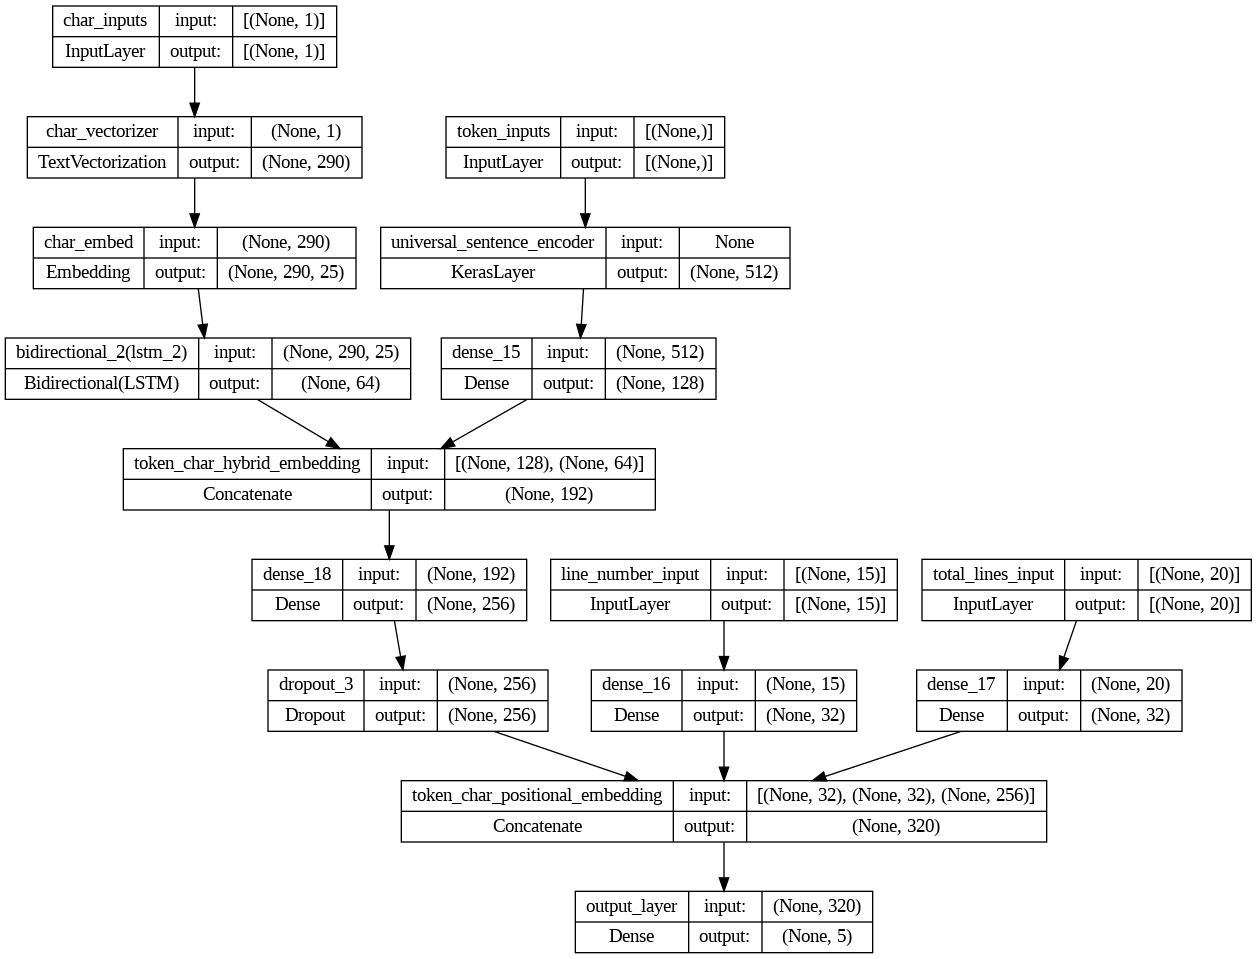

In [114]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [116]:
# Compile token, char, and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data

In [117]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [118]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 288s 489ms/step - loss: 1.1012 - accuracy: 0.7191 - val_loss: 0.9866 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 198s 352ms/step - loss: 0.9671 - accuracy: 0.8153 - val_loss: 0.9501 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 192s 342ms/step - loss: 0.9489 - accuracy: 0.8230 - val_loss: 0.9399 - val_accuracy: 0.8298


In [124]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 69s 73ms/step


array([[0.49923107, 0.11377135, 0.01123847, 0.3572252 , 0.01853385],
       [0.55852294, 0.10102065, 0.0407584 , 0.28970653, 0.00999144],
       [0.28537187, 0.10094889, 0.11808423, 0.4344621 , 0.06113284],
       ...,
       [0.03480687, 0.12898427, 0.03528569, 0.03197843, 0.76894474],
       [0.02593892, 0.29498118, 0.09320739, 0.02600672, 0.5598659 ],
       [0.2156248 , 0.5994373 , 0.09820516, 0.03843796, 0.04829483]],
      dtype=float32)

In [125]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [126]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.45028465510393,
 'precision': 0.8335496719646224,
 'recall': 0.8345028465510393,
 'f1': 0.8336495591659319}

In [127]:
model_1.save('model_1')
model_2.save('model_2')
model_3.save('model_3')
model_4.save('model_4')
model_5.save('model_5')

## Compare model results

In [128]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.657487,0.783213,0.786575,0.784043
pretrained_token_embed,71.239905,0.712915,0.712399,0.709448
custom_char_embed_conv1d,66.212101,0.654174,0.662121,0.651834
hybrid_char_token_embed,78.875943,0.790395,0.788759,0.788770
tribrid_pos_char_token_embed,83.450285,0.833550,0.834503,0.833650


In [129]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

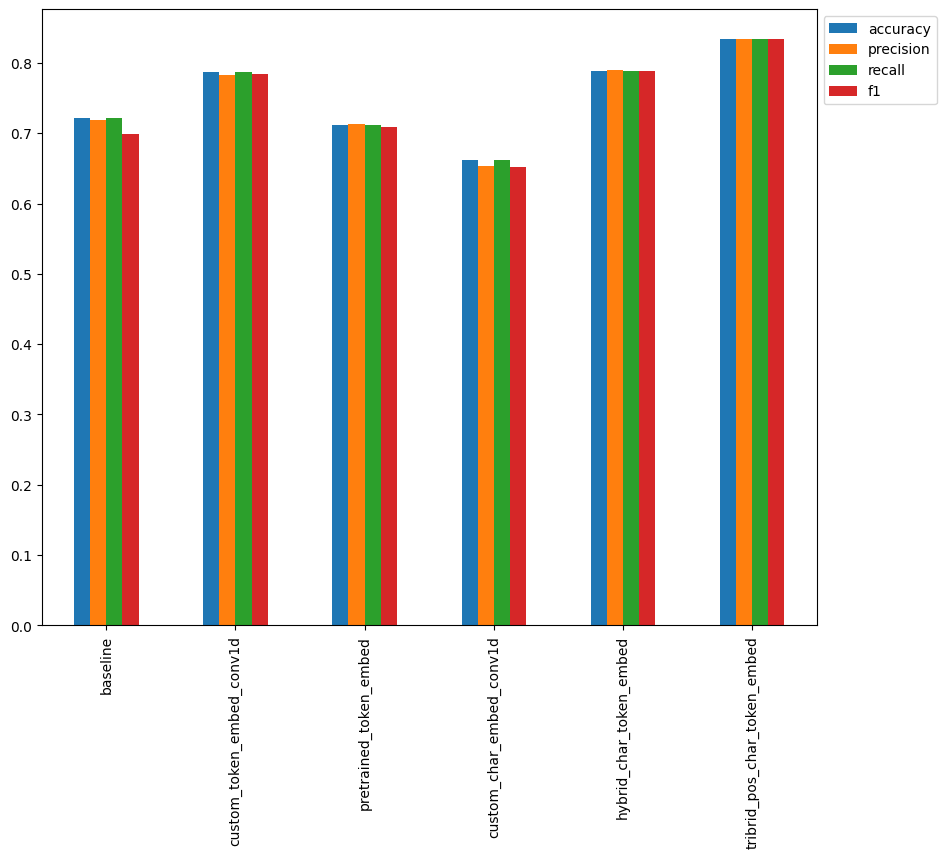

In [130]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar', figsize = (10 , 8)).legend(bbox_to_anchor = (1.0, 1.0))

<Axes: >

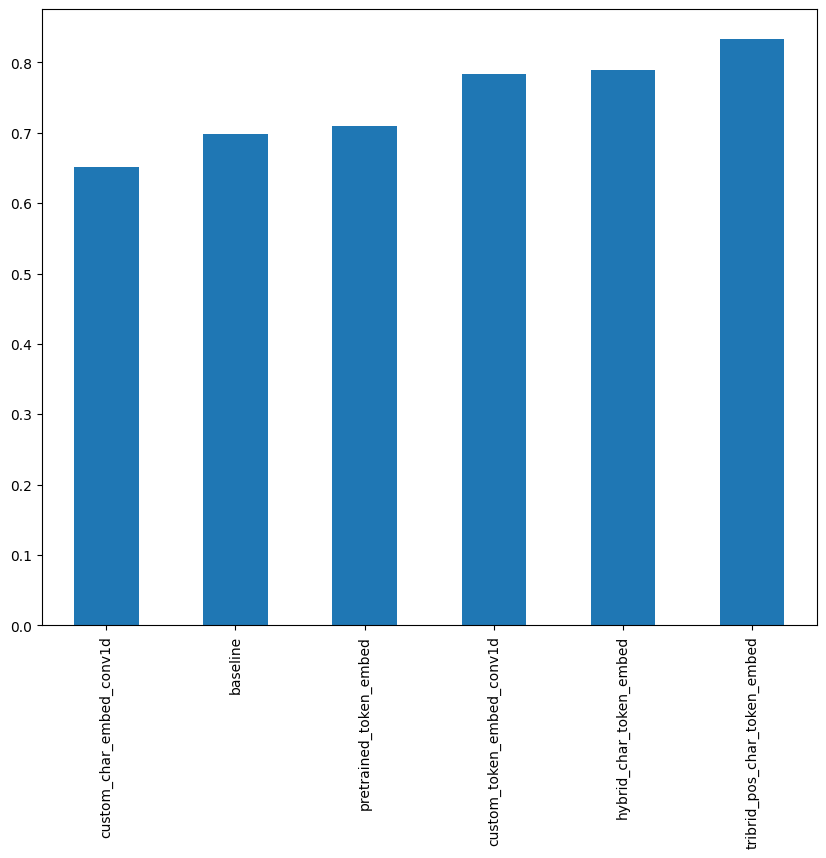

In [133]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10 , 8))

### Save and load model

In [134]:
# Save the best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model')

In [135]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [137]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 85s 85ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [138]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.45028465510393,
 'precision': 0.8335496719646224,
 'recall': 0.8345028465510393,
 'f1': 0.8336495591659319}

In [140]:
!zip -r /content/model_1.zip /content/model_1
!zip -r /content/model_2.zip /content/model_2
!zip -r /content/model_3.zip /content/model_3
!zip -r /content/model_4.zip /content/model_4
!zip -r /content/model_5.zip /content/model_5

updating: content/model_1/ (stored 0%)
updating: content/model_1/keras_metadata.pb (deflated 87%)
updating: content/model_1/saved_model.pb (deflated 68%)
updating: content/model_1/assets/ (stored 0%)
updating: content/model_1/variables/ (stored 0%)
updating: content/model_1/variables/variables.index (deflated 58%)
updating: content/model_1/variables/variables.data-00000-of-00001 (deflated 41%)
updating: content/model_1/fingerprint.pb (stored 0%)
  adding: content/model_2/ (stored 0%)
  adding: content/model_2/keras_metadata.pb (deflated 85%)
  adding: content/model_2/saved_model.pb (deflated 68%)
  adding: content/model_2/assets/ (stored 0%)
  adding: content/model_2/variables/ (stored 0%)
  adding: content/model_2/variables/variables.index (deflated 78%)
  adding: content/model_2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_2/fingerprint.pb (stored 0%)
  adding: content/model_3/ (stored 0%)
  adding: content/model_3/keras_metadata.pb (deflated 87%)
  a

### Evaluate model on test dataset
Let's make predictions on the test dataset and evaluate them.

In [144]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [145]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                  verbose = 1)
test_preds = tf.argmax(test_pred_probs, axis = 1)
test_preds[:10]

942/942 [==============================] - 69s 73ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [146]:
# Evaluate loaded model test predictions
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 82.84718765555003,
 'precision': 0.8272865602547175,
 'recall': 0.8284718765555003,
 'f1': 0.8275489037703962}


It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

### Find most wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [147]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 7.69 s, sys: 19.7 ms, total: 7.71 s
Wall time: 7.73 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 


Now we'll enrich our test DataFame with a few values:

* A `prediction` (string) column containing our model's prediction for a given sample.
* A `pred_prob` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `correct` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [148]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.470037,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.322766,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.761065,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.673922,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.725272,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.892243,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.512318,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.548564,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.465459,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.553146,True


In [150]:
# Find top 100 most wrong samples
top_100_wrong = test_df[test_df['correct'] == False].sort_values('pred_prob', ascending = False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.949482,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.949322,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.925807,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.921559,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.921228,False
...,...,...,...,...,...,...,...
2575,CONCLUSIONS,clinicaltrials.gov : nct@ .,10,10,BACKGROUND,0.831093,False
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.830931,False
18191,RESULTS,se game clinicians were e-mailed @ question ev...,5,17,METHODS,0.830750,False
12304,BACKGROUND,"the severity of psychiatric symptoms , as meas...",2,16,METHODS,0.830680,False


Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [151]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9494818449020386, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9493224024772644, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9258068203926086, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9215594530105591, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9212281107902527, Line number: 15, Total lines: 15

Text:
-lsb- netherlands trial register ( http://www.trialregister.nl/trialreg/index.asp ) , nr @ 